In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [210]:
# dynamics definition
numPlayers = 4;
T = 10;
A = np.eye(2);
B = np.zeros((2, 1, numPlayers))
B[:,:,0] = np.array([[1], [0]]);
B[:,:,1] = np.array([[1], [-1]])/np.sqrt(2);
B[:,:,2] = np.array([[1], [1]])/np.sqrt(2);
B[:,:,3] = np.array([[0], [-1]]);
G = np.zeros((2*T, T*1 -1, numPlayers)); # 2 is the row dim of B, 1 is the column dim of B
H = np.zeros((T*2, 2));
for p in range(numPlayers):
    for col in range(T):
        Abar = np.eye(2); row=col+1;
        while row < T:
            G[row*2: (row+1)*2, col, p] = np.squeeze(Abar.dot(B[:,:,p]));
            if p == 0:
                H[col*2:(col+1)*2,:] = 1.0*Abar;
            Abar  = Abar.dot(A);
            row += 1;
        if p == 0:
            H[col*2:(col+1)*2,:] = 1.0*Abar;
Rscaler = 10.;
Q = np.eye(2);
R = Rscaler*np.eye(1);
print (G[:,:,3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [212]:
# derive the step sizes
J = np.zeros(((T-1)*numPlayers,(T-1)*numPlayers));
diagQ = np.eye(2*T); diagR = Rscaler*np.eye(T-1);
for i in range(T):
    diagQ[i*2: 2*(i+1), 2*i: 2*(i+1)] = Q;
    if i < T-1:
        diagR[i: (i+1), i: (i+1)] = R;
    
for i in range(numPlayers):
    for j in range(numPlayers):
        J[(T-1)*i:(T-1)*(i+1), (T-1)*j:(T-1)*(j+1)]  = G[:,:,i].T.dot(diagQ).dot(G[:,:,j]);
        if i == j:
            J[(T-1)*i:(T-1)*(i+1), (T-1)*i:(T-1)*(i+1)] += diagR;
S = 0.5*(J + J.T);  
eigS, eigVecS = np.linalg.eig(S.T.dot(S));
# print (eigS);
alpha = np.min(eigS); 
eigJ, eigVecJ = np.linalg.eig(J.T.dot(J));
beta = np.max(eigJ);
gammai = 3*np.sqrt(alpha)/beta;
# gammai= alpha/beta;

print (gammai)
dim, dim2 = J.shape;
barA = np.eye(dim) - gammai*J; 
w, v = np.linalg.eig(barA);
print (w)            


(0.00432130085556121+0j)
[0.6399458 +0.j 0.92093338+0.j 0.6399458 +0.j 0.94956441+0.j
 0.92093338+0.j 0.94339668+0.j 0.94339668+0.j 0.94956441+0.j
 0.95207672+0.j 0.95207672+0.j 0.95331742+0.j 0.95331742+0.j
 0.95399356+0.j 0.95399356+0.j 0.95456618+0.j 0.95456618+0.j
 0.9543717 +0.j 0.9543717 +0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j]


In [4]:
print(J.shape)

(36, 36)


In [235]:
K = 100; # number of times to iterate
# run gradient dynamics
x0 = 5*np.random.rand((2)) + np.array([-0.5, -0.5]);
ut = np.zeros((numPlayers*(T-1),K));
Jt = np.zeros((K, numPlayers));
ut[:,0] = np.random.rand((numPlayers*(T-1)));
Hstacked = np.zeros((numPlayers*(T-1), 2));

for p in range(numPlayers):
    Hstacked[p*(T-1):(p+1)*(T-1), :] = G[:, :, p].T.dot(diagQ).dot(H);
     
xt = np.zeros((T*2, K))    
for k in range(K):
    if k> 0:
        ut[:, k] = barA.dot(ut[:,k-1]) - gammai*Hstacked.dot(x0);
    xt[:,k] = H.dot(x0);
    for p in range(numPlayers):
#         print((p+1)*T)
        xt[:,k] += G[:,:,p].dot(ut[p*(T-1):(p+1)*(T-1),k]);
    for p in range(numPlayers):  
#         print(p+1)
        Jt[k,p] = 0.5*xt[:,k].T.dot(diagQ).dot(xt[:,k]) + 0.5*ut[p*(T-1):(p+1)*(T-1), k].T.dot(diagR).dot(ut[p*(T-1):(p+1)*(T-1), k]); 
10
# drawGame(x0, u0)
# print(np.linspace(0,K,100).shape)

/home/sarahli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


10

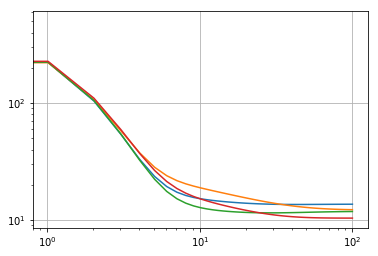

In [236]:
%matplotlib inline
plt.figure()
for p in range(numPlayers):
    plt.plot(np.linspace(0,K,K), Jt[:,p]);
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [237]:
xF = xt[:,0];
print (xF);
print (H)
# uF = ut[:,K-1]
# print (uF);
# print (A)
# fig, ax = plt.subplots()
# ax.set_xlim((-1, 1));
# ax.set_ylim((-1, 2));


# plt.figure()
# for p in range(numPlayers):
#     plt.plot(np.linspace(0,K,100), Jt[:,p]);
# plt.grid()
# plt.yscale('log')
# plt.show()


[ 3.48040183 -0.17962171  4.60934396 -0.48768589  5.62341139 -0.90249477
  7.11198647 -0.61056842  8.31666484 -1.29627981  9.33630479 -1.79608362
 11.16123709 -2.34515747 12.06993052 -2.26728825 13.51530053 -2.94375227
 14.83273806 -3.34819199]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


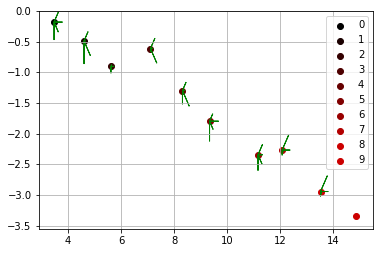

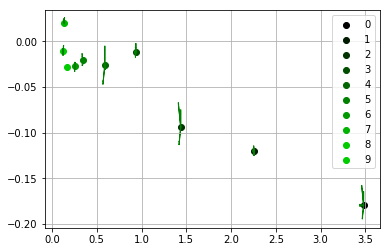

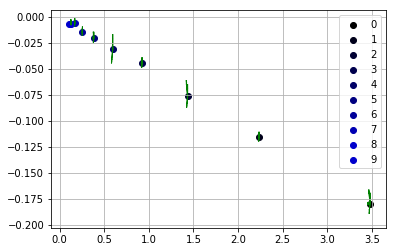

In [238]:
%matplotlib inline

def drawGame(xt, ut):
    plt.figure();
    
    for p in range(numPlayers):
        plt.arrow(x0[0], x0[1],  B[0,0,p]*ut[p], B[1, 0, p]*ut[p], color = 'g');
    plt.scatter(x0[0], x0[1], color = 'b');
    bounds = 0.5*np.array([[-1,-1,1,1], [-1,1,1,-1]]);
    plt.scatter(bounds[0,:], bounds[1,:], color = 'w');
    plt.grid();
    plt.show();
# originX = np.ones(4)*xF[2*i];
# originY = np.ones(4)*xF[2*i+1];
# dx = np.array([B[0,0,0]*ut[numPlayers*i, K-1],
#                B[0,0,1]*ut[numPlayers*i+1, K-1],
#                B[0,0,2]*ut[numPlayers*i+2, K-1],
#                B[0,0,3]*ut[numPlayers*i+3, K-1]]);
# dy = np.array([B[1,0,0]*ut[numPlayers*i, K-1],
#                B[1,0,1]*ut[numPlayers*i+1, K-1],
#                B[1,0,2]*ut[numPlayers*i+2, K-1],
#                B[1,0,3]*ut[numPlayers*i+3, K-1]]);

# print (dx)
# fig, ax = plt.subplots();
# limits = 0.2;
# ax.set_xlim((-limits, limits));
# ax.set_ylim((-limits, limits));
# plt.plot(xF[2*i], xF[2*i+1], color = 'b', label = str(i));
#     originX = np.ones(4)*xF[2*i];
for Kk in [0, K/2, K-1]:
    xF = xt[:,Kk];
    plt.figure();
    for i in range(T-1):
        color = None;
        if Kk == 0:
            color =  (1.*i/T, 0, 0);
        elif Kk == K/2:
            color = (0, 1.*i/T, 0);
        else:
            color = (0, 0, 1.*i/T);
        arrowScale = 4./(Kk+10.);
    #     originX = np.ones(4)*xF[2*i];
    #     originY = np.ones(4)*xF[2*i+1];
        dx = np.array([B[0,0,0]*ut[numPlayers*i, Kk]*arrowScale,
                       B[0,0,1]*ut[numPlayers*i+1, Kk]*arrowScale,
                       B[0,0,2]*ut[numPlayers*i+2, Kk]*arrowScale,
                       B[0,0,3]*ut[numPlayers*i+3, Kk]*arrowScale]);
        dy = np.array([B[1,0,0]*ut[numPlayers*i, Kk]*arrowScale,
                       B[1,0,1]*ut[numPlayers*i+1, Kk]*arrowScale,
                       B[1,0,2]*ut[numPlayers*i+2, Kk]*arrowScale,
                       B[1,0,3]*ut[numPlayers*i+3, Kk]*arrowScale]);
        # plt.arrow(originX, originY,  dx, dy, color = 'g');
        for p in range(numPlayers):
    #         print(xF[2*i], xF[2*i+1],  dx[p], dy[p])
            plt.arrow(xF[2*i], xF[2*i+1],  dx[p], dy[p], color = 'g');
        plt.scatter(xF[2*i], xF[2*i+1], color=color, label = str(i));
    plt.scatter(xF[2*(T-1)], xF[2*(T-1)+1], color =color, label = str(T - 1));
    plt.grid(); plt.legend();plt.show(); 
# plt.grid();
# # plt.legend()
# plt.show()

In [224]:
xF = xt[:,0];
print(xF)
print(xF[::2])
print(xF[1::2])

[ 0.54595686  1.20641941  1.76596875  0.2929929   2.89024334 -0.14847922
  4.54110108 -0.46075093  6.55543457 -1.21132336  8.44173585 -2.10723752
  9.53513558 -1.72262125 10.6949736  -2.38797458 11.23036287 -3.11302617
 12.44069739 -3.61741648]
[ 0.54595686  1.76596875  2.89024334  4.54110108  6.55543457  8.44173585
  9.53513558 10.6949736  11.23036287 12.44069739]
[ 1.20641941  0.2929929  -0.14847922 -0.46075093 -1.21132336 -2.10723752
 -1.72262125 -2.38797458 -3.11302617 -3.61741648]


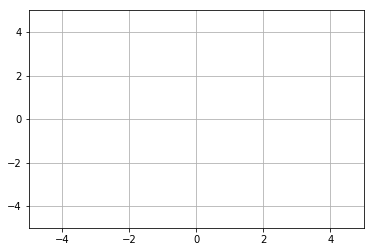

In [247]:
%matplotlib inline
fig = plt.figure()
limits = 5;
ax = plt.axes(xlim=(-limits, limits), ylim=(-limits, limits));
line, = ax.plot([], [], 'o-', lw = 3);
plt.grid();

def init(): 
    line.set_data([],[]);
    return (line,)
def animate(i):
#     ax.clear();
    xF = xt[:,i];
    line.set_data(xF[::2], xF[1::2])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func = init, frames=K, interval = 50, blit=True);


In [248]:
HTML(anim.to_html5_video())